# 배치정규화를 이용한 성능 최적화
- FashionMNIST 데이터셋을 활용한 정규화, 드롭아웃

In [52]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.models as models
import argparse
from torchvision import transforms, datasets
from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
trainset = torchvision.datasets.FashionMNIST(root='/', train=True, 
                                        download=True, 
                                        transform=transforms.ToTensor())

In [23]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

In [24]:
# 데이터셋 분리
images, labels = next(iter(trainloader))

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
0


In [25]:
# 배치 정규화가 적용되지 않은 네트워크
class NormalNet(nn.Module):
    def __init__(self): 
        super(NormalNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1).cuda()
        x = self.classifier(x)
        return x

In [26]:
# 배치 정규화가 포함된 네트워크
class BNNet(nn.Module):
    def __init__(self): 
        super(BNNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

- 배치 정규화 BatchNorm1d에서 파라미터는 특성 개수로 이전 계층의 출력 채널
- 배치 정규화의 위치
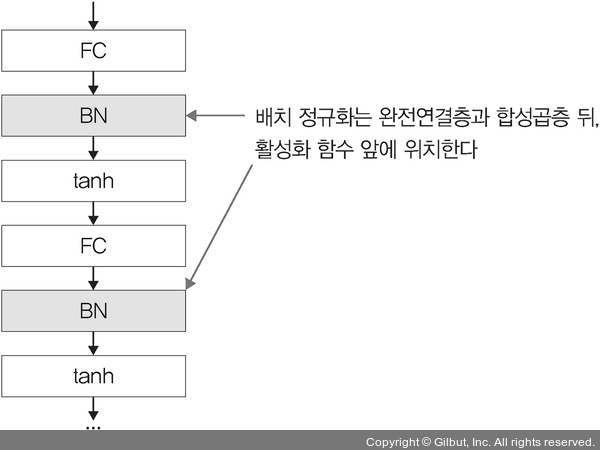

In [27]:
# 배치 정규화가 적용되지 않은 모델 선언
model = NormalNet().to(device)
print(model)

NormalNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [28]:
# 배치 정규화가 적용된 모델 선언
model_bn = BNNet().to(device)
print(model_bn)

BNNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [29]:
# 데이터셋 메모리로 불러오기
batch_size=512
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

- 학습을 위한 용도로 배치 사이즈 512 설정

In [30]:
# 옵티마이저, 손실 함수
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

In [ ]:
# 모델 학습
loss_arr = []
loss_bn_arr = []
max_epochs = 20

for epoch in range(max_epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(inputs)  
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        opt_bn.zero_grad()
        outputs_bn = model_bn(inputs).cuda()
        loss_bn = loss_fn(outputs_bn, labels)
        loss_bn.backward()
        opt_bn.step()
        
        loss_arr.append(loss.item())
        loss_bn_arr.append(loss_bn.item())
           
    plt.plot(loss_arr, 'yellow', label='Normal')
    plt.plot(loss_bn_arr, 'blue', label='BatchNorm')    
    plt.legend()
    plt.show()

- kernel dead

# 드롭아웃을 이용한 성능 최적화

In [31]:
# 데이터셋의 분포를 출력하기 위하 전처리 
N = 50
noise = 0.3

x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

- 훈련 데이터셋이 -1~1의 값을 갖도록 조정
    - torch.linsapcer() : 주어진 범위에서 균등한 값을 갖는 텐서 생성 -> -1~1의 범위에서 N개의 균등한 값을 갖는 텐서 생성
    - torch.unsqueeze() : 차원을 늘리기 위해 사용
- 훈련 데이터셋 값의 범위가 정규분포를 갖도록 조정

In [ ]:
# 데이터 분포를 그래프로 출력
plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
plt.legend()
plt.show()

- kernel dead

In [32]:
# 드롭아웃을 위한 모델 생성
N_h = 100
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

model_dropout = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

In [33]:
# 옵티마이저와 손실 함수 지정
opt = torch.optim.Adam(model.parameters(), lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss().to(device)

In [ ]:
# 모델 학습
max_epochs = 1000
for epoch in range(max_epochs):    
    pred = model(x_train)
    loss = loss_fn(pred, y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    pred_dropout = model_dropout(x_train)
    loss_dropout = loss_fn(pred_dropout, y_train)
    opt_dropout.zero_grad()
    loss_dropout.backward()
    opt_dropout.step()    
    
    if epoch % 50 == 0:        
        model.eval()
        model_dropout.eval()
        
        test_pred = model(x_test)
        test_loss = loss_fn(test_pred, y_test)
        
        test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = loss_fn(test_pred_dropout, y_test)
        
        plt.scatter(x_train.data.numpy(), y_train.data.numpy(), c='purple', alpha=0.5, label='train')
        plt.scatter(x_test.data.numpy(), y_test.data.numpy(), c='yellow', alpha=0.5, label='test')
        plt.plot(x_test.data.numpy(), test_pred.data.numpy(), 'b-', lw=3, label='normal')
        plt.plot(x_test.data.numpy(), test_pred_dropout.data.numpy(), 'g--', lw=3,  label='dropout')
        
        plt.title('Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f' % (epoch, test_loss, test_loss_dropout))
        plt.legend()
        model.train()
        model_dropout.train()        
        plt.pause(0.05)

- kernel dead

# 조기 종료를 이용한 성능 최적화

In [34]:
# 데이터셋 전처리
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [35]:
# 데이터셋 로드
train_dataset = datasets.ImageFolder(
    root=r'./data/archive/train/',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=r'./data/archive/test/',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

In [36]:
# 모델 정의(사전 학습된 ResNet50)
def resnet50(pretrained=True, requires_grad=False):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2)
    return model

- requires_grad == False : 파라미터를 고정하여 backward() 중에 기울기가 계산 x
- requires_grad == True : 파라미터 값이 backward() 기울기 계산에 반영
- 마지막 분류를 위한 계층은 학습을 진행

In [37]:
# 학습률 감소
class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=self.patience,
            factor=self.factor,
            min_lr=self.min_lr,
            verbose=True
        )

    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

- ReduceLR0nPlateau : 검증 데이터셋에 대한 오차의 변동이 없으면 학습률을 factor배 감소
- mode : 언제 학습률을 조정할지에 대한 기준 -> min/max
    - 검증 데이터셋에 대한 모델의 정확도를 기준으로 하면 max, 검증 오차를 기준으로 하면 min으로 설정
- patience : 학습률을 업데이트하기 전에 몇 번의 에포크를 기다려야 하는지 결정
- factor : 학습률을 얼마나 감소시킬지를 지정 -> 새로운 학습률은 기존 학습률 * factor
- min_lr : 학습률의 하한선 지절
- verbose : 조기 종료의 시작과 끝을 출력하기 위해 사용
    - 1로 사용하면 조기 종료가 적용되면 적용되었다고 화면에 출력 / 0은 출력 x
- 콜백 함수(callback) : 개발자가 명시적으로 함수를 호출하는 것이 아니라 개발자는 단지 함수 등록만 하고 특정 이벤트 발생에 의해 함수를 호출하고 처리하도록 하는 것

In [38]:
# 조기 종료
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path='./data/checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path # 모델이 저장될 경로

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

- patience : 오차 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄지 지정
- delta : 오차가 개선되고 있다고 판단하기 위한 최소 변화량 -> delta보다 적다면 개선이 없다고 판단
- 파이토치에서는 조기 종료 함수 자체를 사용자가 직접 구현해야함

In [59]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
args = vars(parser.parse_args())

usage: ipykernel_launcher.py [-h] [--lr-scheduler] [--early-stopping]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\sjy54\AppData\Roaming\jupyter\runtime\kernel-bcd3c486-c116-45c4-b638-042aae2b1903.json


SystemExit: 2

- jupyter notebook과 parser는 같이 사용 어려움

In [ ]:
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss'
    acc_plot_name = 'lrs_accuracy'
    model_name = 'lrs_model'
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss'
    acc_plot_name = 'es_accuracy'
    model_name = 'es_model'

In [41]:
# 사전 훈련된 모델의 파라미터 확인
print(f"Computation device: {device}\n")
model = resnet50(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Computation device: cpu



C:\Users\sjy54\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sjy54\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\sjy54/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:08<00:00, 11.6MB/s]


23,512,130 total parameters.
4,098 training parameters.


In [50]:
# 옵티마이저와 손실 함수
lr = 0.001
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [43]:
loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
model_name = 'model'

In [45]:
# 모델 학습 함수
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size)) # 훈련 진행 과정을 시각적으로 표현

    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [46]:
# 모델 검증 함수
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))

    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()

        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [ ]:
# 모델 학습
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []

start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

In [ ]:
# 모델 학습 결과 출력
print('Saving loss and accuracy plots...')
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"../chap08/img/{acc_plot_name}.png")
plt.show()
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"../chap08/img/{loss_plot_name}.png")
plt.show()

print('Saving model...')
torch.save(model.state_dict(), f"./data/{model_name}.pth")
print('TRAINING COMPLETE')